In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt



width = 5.5
dpi = 100

sns.set_context("paper")
sns.set_style("white", {
    'figure.figsize' : (5.51, 5.51/1.61),
    'figure.dpi': 100,
    'image.cmap': 'viridis',
    'xtick.major.size': 3.5,
    'xtick.major.size': 3.5,
    'xtick.minor.size' : 1.75,
    'xtick.minor.visible' : True,
    'ytick.major.size': 3.5,
})

plt.rc("figure", dpi=100)

One of our reviewers asked us to report the percent of time that precipitation is negative versus positive.

In [44]:
path = "../data/output/model.VaryT-20/3/5/columns.nc"
path_2d = "../data/raw/2/NG_5120x2560x34_4km_10s_QOBS_EQX/coarse/2d/all.nc"

nn = xr.open_dataset(path).isel(x=slice(0, 64))
d2d = xr.open_dataset(path_2d)


# merge all the 2D fields together
ds = xr.merge([nn.drop(['sl', 'qt', 'z']), d2d], join='inner').dropna('time')

# Positivity of Precipitation budget

In [45]:
evap = ds.LHF /2.51e6 / 1000
evap.attrs['units'] = 'm/s'

In [ ]:
prec = (evap - ds.QNN)*86400 * 1000
# drop the initial time point

np.isnan(prec).any()

In [ ]:
npos = int((prec >= 0).sum())
nneg = int((prec < 0).sum())
ntot = npos + nneg

print("Fraction of time negative: ", nneg / ntot)

However, the fraction of the time which precipitation is negative is not the most informative. It is also important to know the magnitude. In other words, what is the average negative rainfall vs average positive rainfall.

In [ ]:
mu_pos = prec.values[prec >= 0].mean()
mu_neg = prec.values[prec < 0].mean()

print("Mu [P < 0], Mean P >= 0")
print(mu_neg, mu_pos)

In [ ]:
fraction_neg = float(prec.values[prec< 0 ].sum()/prec.sum())
print("Fraction of total rainfall which is negative:", fraction_neg)

In [ ]:
fig, ax = plt.subplots(figsize=(3.2,3.2/1.61), constrained_layout=True)

ax.hist(prec.values.ravel(), bins=200);
ax.set_xlim([-10, 90])
ax.set_xlabel('mm/day')
ax.set_ylabel('Count')
ax.axvline(0.0, color='k')
ax.text(10, 60000, " %.0f%% of samples with P < 0"%(100*nneg/ntot))
ax.text(10, 50000, "%.0f%% of rainfall from P < 0"%(100 * fraction_neg))
ax.set_title("Precipitation Distribution for NN");


for sp in ['right', 'top']:
    ax.spines[sp].set_visible(False)
    
plt.savefig("../reports/paper/si1.pdf")

# Energy conservation

In this context, energy conservation means $\langle c_p (Q_1 - Q_r) + L_v Q_2 \rangle  = 0 $. The vertical integral of the radiation is given by 
$c_p \langle Q_r \rangle = \text{Net TOA}\downarrow - \text{Net Rad SFC}\downarrow$. SAM provides these variables in the 2D file, but I am not sure about the sign convection. Net SW at TOA should be positive, and LW negative if the flux is incoming.

In [ ]:
float(ds.SWNT.mean()), float(ds.LWNT.mean())

In [ ]:
float(ds.SWNS.mean()), float(ds.LWNS.mean())

It appears that the sign convection is different between LW and SW. 

In [26]:
net_TOA = ds.SWNT - ds.LWNT 
net_SFC = ds.SWNS - ds.LWNS - ds.LHF - ds.SHF
net_rad = ds.SWNT - ds.LWNT - (ds.SWNS - ds.LWNS)

This shows that around 40 W/m2 are staying in the atmosphere over this region. This energy budget should be closed by heat transport due to the circulation.

So, how well does the NN conserve this energy? We can quantify this by the "imbalance" statistic:

$$ I = c_p \langle Q_1 \rangle + L_v \rho_w \langle Q_2 \rangle  -  (TOA_{r\downarrow} - SFC_{r\downarrow} + SHF + LHF)$$

In [27]:
rho_w = 1000
Lv = 2.51e6

imbalance = ds.SNN + ds.QNN * rho_w * Lv  - (net_rad + ds.SHF + ds. LHF)

In [28]:
print("Mean imbalance %f W/m2"%imbalance.mean())
print("Std of imbalance %f W/m2"%imbalance.std())

Mean imbalance -5.328006 W/m2
Std of imbalance 92.498276 W/m2


The mean imbalance is pretty low overall. On the other hand, the standard deviation of the imbalance is pretty high probably because the neural network includes the effect of horizontal mixing and because the approximations used to compute the large-scale forcing. What does the time series look like?

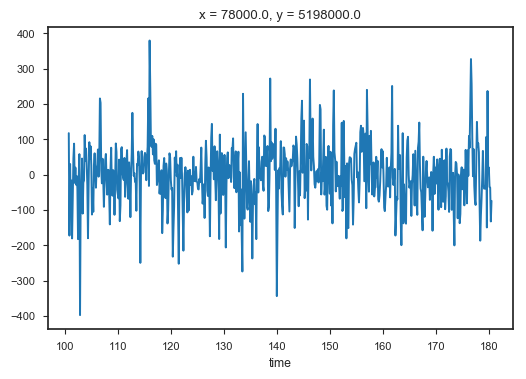

In [47]:
imbalance.isel(x=0, y=8).plot()

We can see that the time series is pretty noisy, but does show some coherent structures  around day 105 and 178, for example.